# Example (2) 映画レビュー分類問題 (binary classification)

- 基本的に，["Deep Learning with Python"](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438/)のSection 3.4(68-77ページ)を元にしている．  
- [原本のコード](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/3.5-classifying-movie-reviews.ipynb)も入手可能であるが，それを解説を兼ねて多少改編している．  

## (1) Prepare dataset: IMDB movie review dataset

- Data format: [N,?]
- Training set: labelled 25,000 text sequences
- Test set: labelled 25,000 text sequences
- テキストの長さはそれぞれ異なるので，特定できない  

In [1]:
## imdb dataset is also embedded in Keras framework, but it is pickled in old format.
from keras.datasets import imdb

# modify the default parameters of np.load
import numpy as np
from pkg_resources import parse_version

## we need small modification to handle old-pickled data
np_pickle = parse_version(np.__version__) < parse_version('1.17.0')
if np_pickle:
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000) 

if np_pickle:
    np.load = np_load_old

Using TensorFlow backend.


In [2]:
## review text is encoded as a vector sequence
print(train_data[0])
print(train_labels[0]) ## 0: negative / 1: positive

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


In [3]:
## decoding from encoded-label to English word
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i-3, '?') for i in train_data[0]]) ## 0:padding / 1:start / 2:unknown
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## (2) Data conversion for training

- x: 単語のシーケンス $\rightarrow$ 単語保持可否を表す10,000次元のベクトル [0:含まない, 1:含む]  
- y: 離散データ (整数型) [0,1] $\rightarrow$ 連続データ (浮動小数点数) [0.0:1.0]  

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test  = vectorize_sequences(test_data)

In [5]:
print(x_train[0])

[0. 1. 1. ... 0. 0. 0.]


In [6]:
y_train = np.asarray(train_labels).astype('float32')
y_test  = np.asarray(test_labels).astype('float32')

## (3) Prepare model

- Fully connectedで(隠し2層)単純なネットワークを構成する  
- 二値識別(binary classification)なので，訓練のloss関数としてbinary_crossentropyを用いる  

In [7]:
from keras import models
from keras import layers

## build model (fully-connected layer)
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense( 1, activation='sigmoid'))

In [8]:
from keras import optimizers
from keras import losses
from keras import metrics

## compile the model with (custom) optimizers, losses and metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## (4) Training & testing neural network

### (4-i) Training model

In [9]:
## separating data for validation (0~9999) / training (10000~24999)
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val,y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 160us/step - loss: 0.5226 - binary_accuracy: 0.7955 - val_loss: 0.3943 - val_binary_accuracy: 0.8722
Epoch 2/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.3116 - binary_accuracy: 0.9036 - val_loss: 0.3076 - val_binary_accuracy: 0.8845
Epoch 3/20
15000/15000 [==============================] - 2s 116us/step - loss: 0.2260 - binary_accuracy: 0.9257 - val_loss: 0.2797 - val_binary_accuracy: 0.8886
Epoch 4/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.1763 - binary_accuracy: 0.9440 - val_loss: 0.2879 - val_binary_accuracy: 0.8846
Epoch 5/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1434 - binary_accuracy: 0.9545 - val_loss: 0.2847 - val_binary_accuracy: 0.8875
Epoch 6/20
15000/15000 [==============================] - 2s 118us/step - loss: 0.1203 - binary_accuracy: 0.9615 - val_loss: 0.2938 - val_bi

### (4-ii) Visualizing the Training Progress

- 訓練課程はmodel.fit()の既に出力として保存されている  
- その訓練課程をmatplotlibで可視化する  

In [11]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


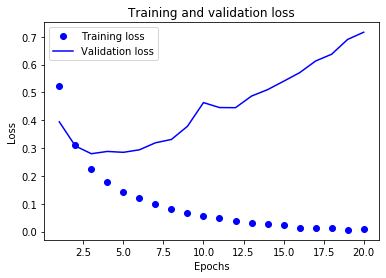

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc = history_dict['binary_accuracy']
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss_values    , 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b' , label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

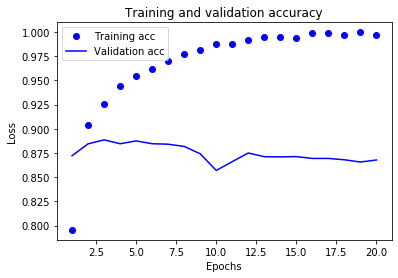

In [13]:
plt.clf() ## clear the figure
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b' , label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Re-training a model from scratch

In [14]:
## another (but the same structured) model
model2 = models.Sequential()
model2.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense( 1, activation='sigmoid'))
model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## training another model with relatively small epochs
model2.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
print(results)

Epoch 1/4
25000/25000 [==============================] - 2s 74us/step - loss: 0.4782 - accuracy: 0.8124
Epoch 2/4
25000/25000 [==============================] - 2s 71us/step - loss: 0.2688 - accuracy: 0.9068
Epoch 3/4
25000/25000 [==============================] - 2s 71us/step - loss: 0.2046 - accuracy: 0.9264
Epoch 4/4
25000/25000 [==============================] - 3s 118us/step
[0.7805381040310859, 0.8509200215339661]


In [15]:
model.predict(x_test)

array([[0.00802989],
       [1.        ],
       [0.9560808 ],
       ...,
       [0.00220481],
       [0.0051692 ],
       [0.8610219 ]], dtype=float32)

(end)